# WikiArt Dataset Demo

This notebook demonstrates how to use the WikiArt dataset utilities to process images, extract edge features, and create dataloaders for model training.

In [1]:
!pip install -r ../requirements.txt

  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import json
from PIL import Image
import cv2

# Add the root directory to the path
sys.path.append('..')

from src.utils.wikiart_dataloader import WikiArtDataset, WikiArtTorchDataset, create_dataloaders
from src.preprocessing.edge_detection import process_artwork, extract_edges
from src.features.line_features import extract_line_features, visualize_lines

# Set display options
plt.rcParams['figure.figsize'] = (12, 10)
pd.set_option('display.max_columns', None)

## 1. Load and Explore the WikiArt Dataset

First, let's load the WikiArt dataset from the CSV file and explore its contents.

In [3]:
# Path to the WikiArt CSV file
csv_path = '../data/wikiart_scraped.csv'

# Create the WikiArt dataset object
dataset = WikiArtDataset(csv_path, cache_dir='../data/image_cache')

# Display basic information about the dataset
print(f"Total number of artworks: {len(dataset.data)}")
print(f"Number of unique styles: {len(dataset.style_to_id)}")
print(f"Unique styles: {list(dataset.style_to_id.keys())}")

2025-03-13 17:20:26,992 - INFO - Loading WikiArt dataset from ../data/wikiart_scraped.csv
2025-03-13 17:20:27,312 - INFO - Loaded dataset with 124170 entries
2025-03-13 17:20:27,317 - INFO - Found 217 unique art styles


Total number of artworks: 124170
Number of unique styles: 217
Unique styles: ['Abbasid-Period', 'Abstract-Art', 'Abstract-Expressionism', 'Academicism', 'Action-painting', 'Amarna', 'American-Realism', 'Analytical-Cubism', 'Analytical\xa0Realism', 'Archaic', 'Art-Brut', 'Art-Deco', 'Art-Informel', 'Art-Nouveau-(Modern)', 'Art-Singulier', 'Automatic-Painting', 'Baroque', 'Biedermeier', 'Byzantine', 'Cartographic-Art', 'Chernihiv-school-of-icon-painting', 'Classical', 'Classical-Realism', 'Classicism', 'Cloisonnism', 'Color-Field-Painting', 'Conceptual-Art', 'Concretism', 'Confessional-Art', 'Constructivism', 'Contemporary', 'Contemporary-Realism', 'Coptic-art', 'Costumbrismo', 'Cretan-school-of-icon-painting', 'Crusader-workshop', 'Cubism', 'Cubo-Expressionism', 'Cubo-Futurism', 'Cyber-Art', 'Dada', 'Digital-Art', 'Divisionism', 'Documentary-photography', 'Early-Byzantine-(c.-–)', 'Early-Christian', 'Early-Dynastic', 'Early-Renaissance', 'Environmental-(Land)-Art', 'Ero-guro', 'Excessiv

In [4]:
# Display the first few rows of the dataset
dataset.data.head()

,Style,Artwork,Artist,Date,Link
0,Early-Dynastic,Narmer Palette,Ancient Egypt,3050 BC,https://uploads3.wikiart.org/00265/images/anci...
1,Early-Dynastic,Box Inlay with a Geometric Pattern,Ancient Egypt,3100-2900 BC,https://uploads2.wikiart.org/00244/images/anci...
2,Old-Kingdom,Khafre Enthroned,Ancient Egypt,2570 BC,https://uploads2.wikiart.org/00305/images/anci...
3,Middle-Kingdom,Stele of the Serpent King (Stela of Djet),Ancient Egypt,3000 BC,https://uploads7.wikiart.org/00305/images/anci...
4,Middle-Kingdom,"Laden Donkeys and Ploughing, Tomb of Djar",Ancient Egypt,2060-2010 BC,https://uploads8.wikiart.org/00244/images/anci...


Style
Romanticism                          3600
Impressionism                        3600
Baroque                              3600
Neoclassicism                        3600
Realism                              3600
                                     ... 
Graffiti-Art                            1
Early-Christian                         1
nd-Intermediate-Period                  1
New-media-art                           1
Stroganov-school-of-icon-painting       1
Name: count, Length: 217, dtype: int64


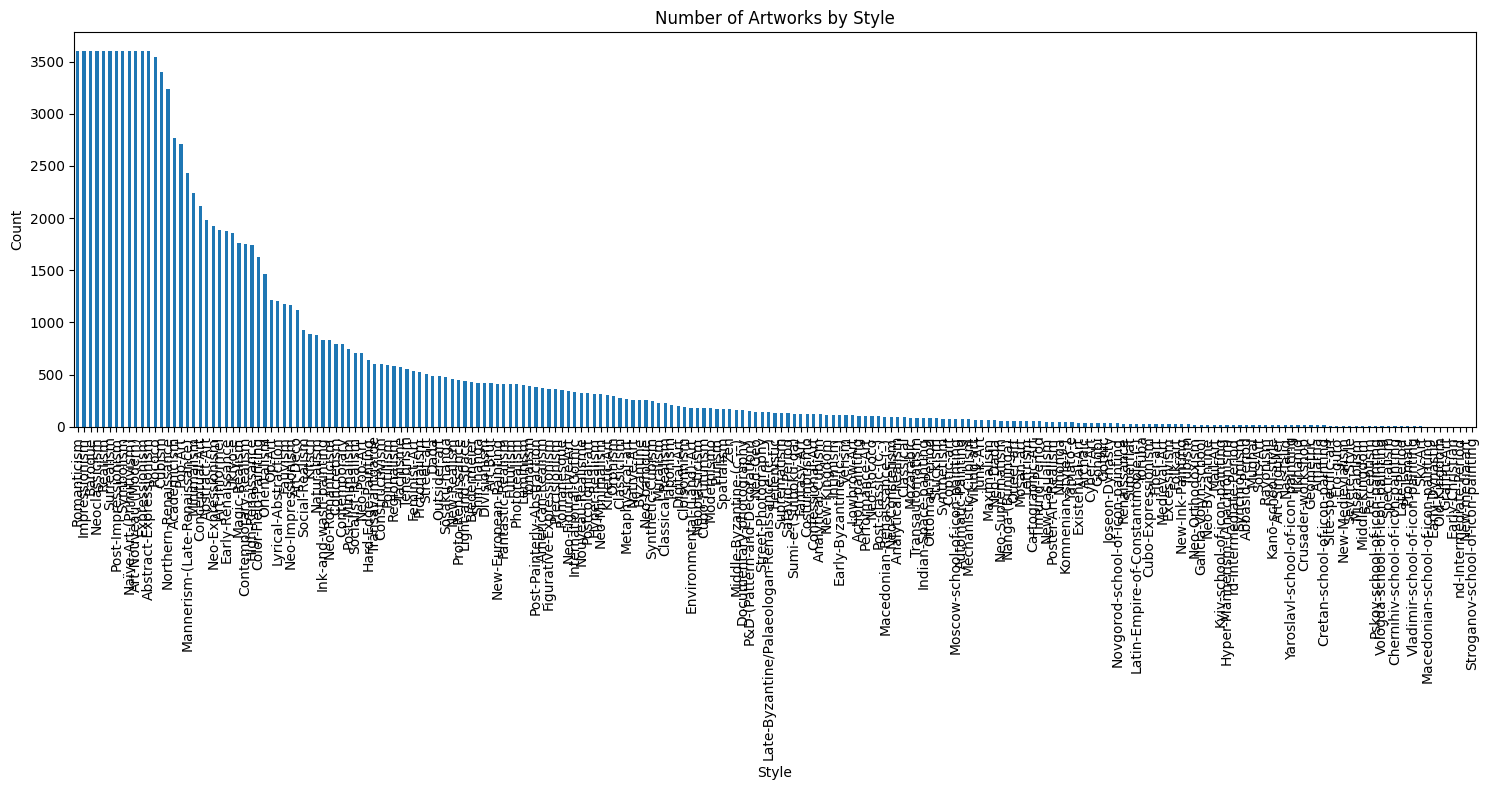

In [5]:
# Count the number of artworks by style
style_counts = dataset.data['Style'].value_counts()
print(style_counts)

# Visualize the distribution of styles
plt.figure(figsize=(15, 8))
style_counts.plot(kind='bar')
plt.title('Number of Artworks by Style')
plt.xlabel('Style')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 2. Split the Dataset

Next, let's split the dataset into training, validation, and test sets while ensuring that the style distribution is maintained.

In [6]:
# Split the dataset
train_df, val_df, test_df = dataset.split_dataset(
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42
)

# Display the sizes of each split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

2025-03-13 17:20:45,143 - INFO - Dataset split: train=86824, val=18530, test=18816


Training set size: 86824
Validation set size: 18530
Test set size: 18816


In [7]:
# Verify that the style distribution is maintained
train_style_counts = train_df['Style'].value_counts(normalize=True)
val_style_counts = val_df['Style'].value_counts(normalize=True)
test_style_counts = test_df['Style'].value_counts(normalize=True)
original_style_counts = dataset.data['Style'].value_counts(normalize=True)

# Compare the distributions
comparison = pd.DataFrame({
    'Original': original_style_counts,
    'Train': train_style_counts,
    'Validation': val_style_counts,
    'Test': test_style_counts
})

# Display the comparison
comparison.head(10)

,Original,Train,Validation,Test
Style,,,,
Abbasid-Period,0.000129,0.000127,0.000108,0.000159
Abstract-Art,0.015946,0.015963,0.016028,0.015784
Abstract-Expressionism,0.028993,0.029024,0.029142,0.028699
Academicism,0.022300,0.022321,0.022396,0.022109
Action-painting,0.000854,0.000852,0.000809,0.000903
Amarna,0.000097,0.000092,0.000054,0.000159
American-Realism,0.003012,0.003006,0.003022,0.003029
Analytical-Cubism,0.000958,0.000956,0.000917,0.001010
Analytical Realism,0.000725,0.000714,0.000702,0.000797


## 3. Download and Process Sample Images

Let's download and process a few sample images to demonstrate the edge extraction and feature calculation.

In [8]:
# Sample a few images from different styles
sample_size = 5
sample_df = train_df.groupby('Style').apply(lambda x: x.sample(min(sample_size, len(x)))).reset_index(drop=True)
sample_df

,Style,Artwork,Artist,Date,Link
0,Abbasid-Period,Device for a Drinking Party,Al-Jazari,1206,https://uploads2.wikiart.org/00295/images/al-j...
1,Abbasid-Period,Figure for Use at Drinking Parties,Al-Jazari,1206,https://uploads6.wikiart.org/00295/images/al-j...
2,Abbasid-Period,The Castle Water Clock,Al-Jazari,1206,https://uploads1.wikiart.org/00295/images/al-j...
3,Abbasid-Period,The Elephant Clock,Al-Jazari,1206,https://uploads2.wikiart.org/00295/images/al-j...
4,Abbasid-Period,The Reckoner's Blood-letting Basin,Al-Jazari,1206,https://uploads4.wikiart.org/00295/images/al-j...
...,...,...,...,...,...
1023,rd-Intermediate-Period,Painted Stela of Djedbastet,Ancient Egypt,825-712 BC,https://uploads2.wikiart.org/00244/images/anci...
1024,rd-Intermediate-Period,Weighing of the Heart (Book of the Dead for th...,Ancient Egypt,1050 BC,https://uploads1.wikiart.org/00244/images/anci...
1025,rd-Intermediate-Period,"Nany Before Osiris, Isis and Nephthys (Book of...",Ancient Egypt,1050 BC,https://uploads7.wikiart.org/00244/images/anci...
1026,rd-Intermediate-Period,Relief Attributed to Petamenophis,Ancient Egypt,710-640 BC,https://uploads7.wikiart.org/00244/images/anci...


In [9]:
# Process the sample images
sample_processed = dataset.preprocess_images(
    sample_df,
    target_size=(512, 512),
    batch_size=5,
    edge_method='canny',
    extract_features=True
)

Processing images:   5%|▍         | 10/206 [01:15<24:30,  7.50s/it]


KeyboardInterrupt: 

In [ ]:
# Function to visualize the processed images
def visualize_processed_images(processed_data, num_samples=5):
    # Sample some images from the processed data
    sample_ids = list(processed_data.keys())[:num_samples]
    
    for artwork_id in sample_ids:
        data = processed_data[artwork_id]
        style = data['style']
        preprocessed = data['preprocessed']
        edges = data['edges']
        
        # Create a figure with 2 subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Display the preprocessed image
        axes[0].imshow(cv2.cvtColor(preprocessed, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"Original: {artwork_id} (Style: {style})")
        axes[0].axis('off')
        
        # Display the edge image
        axes[1].imshow(edges, cmap='gray')
        axes[1].set_title(f"Edges")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print feature information if available
        if 'features' in data:
            features = data['features']
            print(f"Feature summary for {artwork_id}:")
            print(f"  Line count: {features.get('line_count', 'N/A')}")
            print(f"  Average line length: {features.get('avg_line_length', 'N/A'):.2f}")
            print(f"  Line length std: {features.get('line_length_std', 'N/A'):.2f}")
            print(f"  Average line angle: {features.get('avg_line_angle', 'N/A'):.2f}")
            print(f"  Line angle std: {features.get('line_angle_std', 'N/A'):.2f}")
            print(f"  Intersection count: {features.get('intersection_count', 'N/A')}")
            print("\n")

# Visualize the processed images
visualize_processed_images(sample_processed)

## 4. Process and Save the Dataset

Now let's process a subset of the dataset and save the results for future use. In practice, you would run the `wikiart_processor.py` script to process the entire dataset.

In [ ]:
# Process a small subset of each split for demonstration
subset_size = 10  # Adjust this as needed

def sample_balanced_subset(df, size_per_style=2):
    # Sample a balanced subset from each style
    return df.groupby('Style').apply(lambda x: x.sample(min(size_per_style, len(x)))).reset_index(drop=True)

train_subset = sample_balanced_subset(train_df, subset_size)
val_subset = sample_balanced_subset(val_df, subset_size)
test_subset = sample_balanced_subset(test_df, subset_size)

print(f"Training subset size: {len(train_subset)}")
print(f"Validation subset size: {len(val_subset)}")
print(f"Test subset size: {len(test_subset)}")

In [ ]:
# Create output directories
output_dir = '../data/processed_demo'
os.makedirs(output_dir, exist_ok=True)

# Process and save each split
splits = {
    'train': train_subset,
    'val': val_subset,
    'test': test_subset
}

for split_name, split_df in splits.items():
    print(f"Processing {split_name} split...")
    
    # Create output directory for the split
    split_output_dir = os.path.join(output_dir, split_name)
    os.makedirs(split_output_dir, exist_ok=True)
    
    # Process images
    split_processed = dataset.preprocess_images(
        split_df,
        target_size=(512, 512),
        batch_size=5,
        edge_method='canny',
        extract_features=True
    )
    
    # Save processed data
    dataset.save_processed_data(split_processed, split_output_dir)
    
    print(f"Saved {len(split_processed)} processed images to {split_output_dir}")

# Save style mappings to the main output directory
style_mapping = {
    'style_to_id': dataset.style_to_id,
    'id_to_style': {str(k): v for k, v in dataset.id_to_style.items()}
}

with open(os.path.join(output_dir, 'style_mapping.json'), 'w') as f:
    json.dump(style_mapping, f, indent=2)
    
print(f"Processing complete. Results saved to {output_dir}")

## 5. Create PyTorch DataLoaders

Finally, let's create PyTorch DataLoaders for the processed data to use in model training.

In [ ]:
# Create dataloaders from the processed data
dataloaders = create_dataloaders(
    metadata_path=os.path.join(output_dir, 'train', 'metadata.csv'),
    data_dir=os.path.join(output_dir, 'train'),
    batch_size=4,
    image_size=224,
    use_features=True,
    num_workers=2
)

# Display the dataloader sizes
print(f"Training dataloader size: {len(dataloaders['train'].dataset)}")
print(f"Validation dataloader size: {len(dataloaders['val'].dataset)}")
print(f"Test dataloader size: {len(dataloaders['test'].dataset)}")

In [ ]:
# Visualize a batch of data from the training dataloader
def visualize_batch(dataloader):
    # Get a batch of data
    batch = next(iter(dataloader))
    
    # Unpack the batch
    preprocessed = batch['preprocessed']
    edges = batch['edges']
    labels = batch['label']
    artwork_ids = batch['artwork_id']
    
    # Load style mappings
    with open(os.path.join(output_dir, 'style_mapping.json'), 'r') as f:
        style_mapping = json.load(f)
    
    id_to_style = style_mapping['id_to_style']
    
    # Visualize each sample in the batch
    for i in range(len(preprocessed)):
        # Convert tensors to numpy arrays for visualization
        img = preprocessed[i].permute(1, 2, 0).numpy()
        edge = edges[i].permute(1, 2, 0).numpy()
        label = labels[i].item()
        artwork_id = artwork_ids[i]
        
        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        # Convert the edge image to single channel
        edge = edge.squeeze()
        
        # Create a figure with 2 subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Display the preprocessed image
        axes[0].imshow(img)
        axes[0].set_title(f"{artwork_id} (Style: {id_to_style.get(str(label), 'Unknown')})")
        axes[0].axis('off')
        
        # Display the edge image
        axes[1].imshow(edge, cmap='gray')
        axes[1].set_title(f"Edges")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        if 'features' in batch:
            features = batch['features'][i].numpy()
            print(f"Feature vector: {features}")

# Visualize a batch from the training dataloader
visualize_batch(dataloaders['train'])

## 6. Using the WikiArt Dataset in Model Training

Here's an example of how you could use the WikiArt dataset in a model training workflow:

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Example model definition
class ArtStyleClassifier(nn.Module):
    def __init__(self, num_classes, use_features=True):
        super(ArtStyleClassifier, self).__init__()
        
        # Image feature extractor (ResNet-18)
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final FC layer
        
        # Edge image feature extractor
        self.edge_conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Determine the input size for the classifier
        resnet_out = 512  # ResNet-18 feature dimension
        edge_out = 64     # Edge feature dimension
        line_features = 6 if use_features else 0  # Number of line features
        
        self.use_features = use_features
        classifier_input = resnet_out + edge_out + line_features
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Unpack input
        preprocessed = x['preprocessed']
        edges = x['edges']
        
        # Extract features from preprocessed image
        img_features = self.resnet(preprocessed)
        
        # Extract features from edge image
        edge_features = self.edge_conv(edges).view(edges.size(0), -1)
        
        # Combine features
        combined_features = torch.cat([img_features, edge_features], dim=1)
        
        # Add line features if available
        if self.use_features and 'features' in x:
            combined_features = torch.cat([combined_features, x['features']], dim=1)
        
        # Classify
        return self.classifier(combined_features)

# Example training loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for batch in dataloaders[phase]:
                # Move inputs and labels to device
                for k in batch.keys():
                    if isinstance(batch[k], torch.Tensor):
                        batch[k] = batch[k].to(device)
                
                labels = batch['label']
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(batch)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * labels.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return model

# Example usage (commented out to avoid actual training)
'''
# Load style mappings to get the number of classes
with open(os.path.join(output_dir, 'style_mapping.json'), 'r') as f:
    style_mapping = json.load(f)

num_classes = len(style_mapping['style_to_id'])

# Initialize model
model = ArtStyleClassifier(num_classes=num_classes, use_features=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device=device)
'''

## 7. Next Steps

Here are some ways you could extend this work:

1. Process the entire WikiArt dataset using the `wikiart_processor.py` script
2. Experiment with different edge detection methods and parameters
3. Extract additional features or improve the existing feature extraction methods
4. Train and evaluate models on the dataset
5. Analyze the relationship between art styles and extracted features

To process the full dataset, you can run the processor script with appropriate parameters:

In [ ]:
# Example command to process the full dataset (commented out)
'''
# From the command line
python src/preprocessing/wikiart_processor.py \
    --csv-path data/wikiart_scraped.csv \
    --output-dir data/processed \
    --target-size 512 \
    --batch-size 32 \
    --edge-method canny \
    --extract-features
'''